# En fiktiv hälsostudie


In [46]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import src.metrics as M 
import src.viz as V 


In [47]:
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"

In [48]:
#Importera data
df_start = pd.read_csv("data/health_study_dataset.csv")             

In [49]:
# display(df_start.head())
# display(df_start.info())
# display(df_start.describe())
# dup_mask = df_start.duplicated(keep=False)
# dup_mask.sum()    

In [50]:
#Städa data
df = df_start.copy()
df["sex"] = df["sex"].astype("category")  # behövs detta? 
df["smoker"] = df["smoker"].astype("category") # behövs detta? 
# df.info()

## Beskrivande analys

In [51]:
#Första beskrivande analys
stats = (df[["age", "weight", "height", "systolic_bp", "cholesterol"]]
         .agg(["mean", "median", "min", "max"]
              ).round(2))
stats

,age,weight,height,systolic_bp,cholesterol
mean,49.43,73.41,171.85,149.18,4.93
median,50.00,73.20,171.35,149.40,4.97
min,18.00,33.70,144.40,106.80,2.50
max,90.00,114.40,200.40,185.90,7.88


In [52]:
#Uträkning för hur många rökare det finns 
smoker = (df.groupby("smoker", observed= True)["id"]
          .count()
          .reset_index()
          )

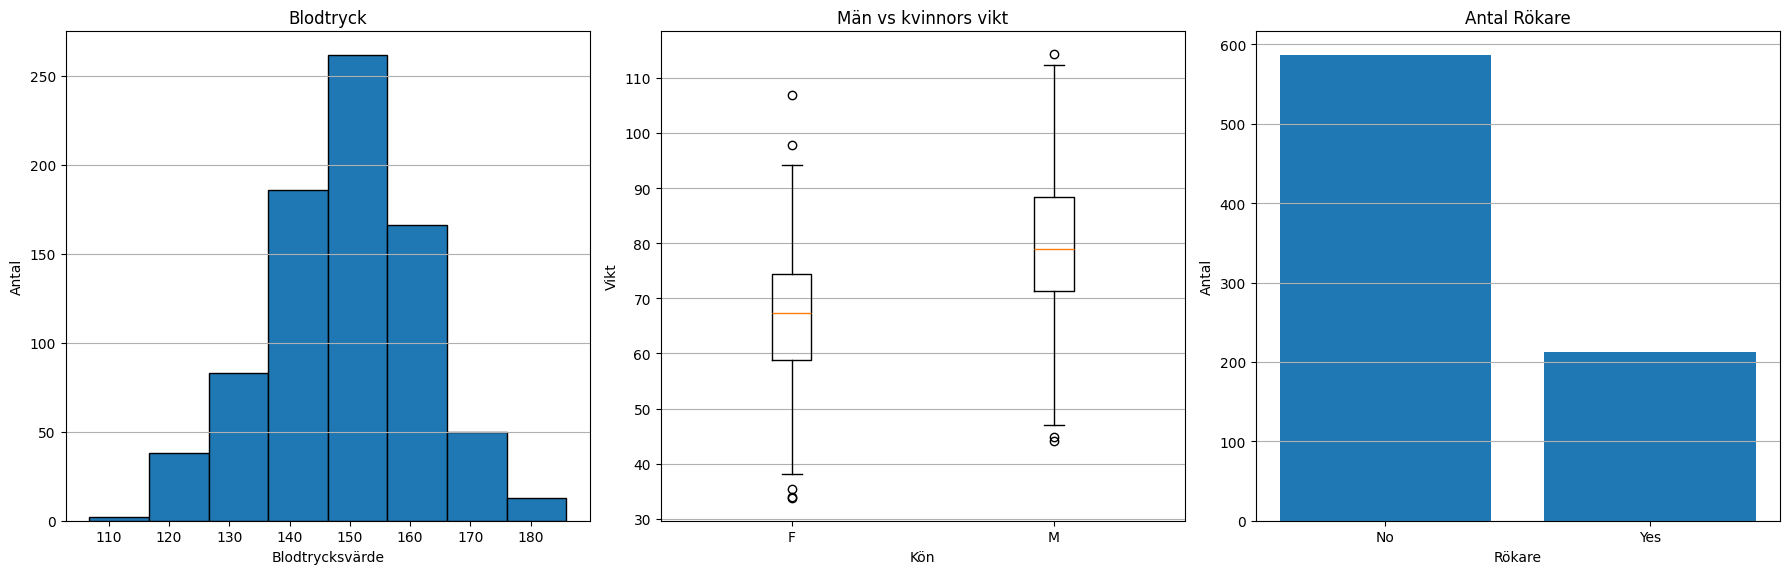

In [53]:
#Visualisering
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

V.histogram(axes[0], df["systolic_bp"], title = "Blodtryck", xlabel = "Blodtrycksvärde" )
V.boxplot(axes[1], [df.loc[df.sex == "F", "weight"], df.loc[df.sex == "M", "weight"]], ["F", "M"], "Män vs kvinnors vikt", "Kön", "Vikt")
V.bar(axes[2], smoker.smoker, smoker.id, "Antal Rökare", "Rökare", "Antal")

plt.show()


### I ovan visuaiseringar kan vi från vår data utläsa följande:  
**Diagram 1:** Hur fördelningen av blodtryck ser ut.   
Det är flest i gruppen som har ett blodtryck på runt 150, och det finns en spridning från ca 110 till ca 180.   
**Diagram 2:** Hur fördelningen av vikt ser ut för kvinnor respektive män.   
Kvinnor har generellt en lägre vikt än män. Medelvikten för män ligger strax under 80kg medan medelvikten för kvinnor ligger under 70kg.  
**Diagram 3:** Hur många rökare respektive icke rökare det finns.  
Det är betydligt fler som inte röker än som röker.  

## Simulering
Hur många människor har sjukdomen. 

In [54]:
verklig_andel = df["disease"].mean()

# Simulering 

np.random.seed(42)
n = 1000
sim = np.random.choice([0.0, 1.0], p = [1-verklig_andel, verklig_andel], size = n)
simulerad_andel = sim.mean()


print(f"Andel personer som har sjukdomen: {verklig_andel:.2%}")
print(f"Simulerad andel personer som har sjukdomen: {simulerad_andel:.2%}")

Andel personer som har sjukdomen: 5.88%
Simulerad andel personer som har sjukdomen: 5.60%


<Figure size 700x500 with 0 Axes>

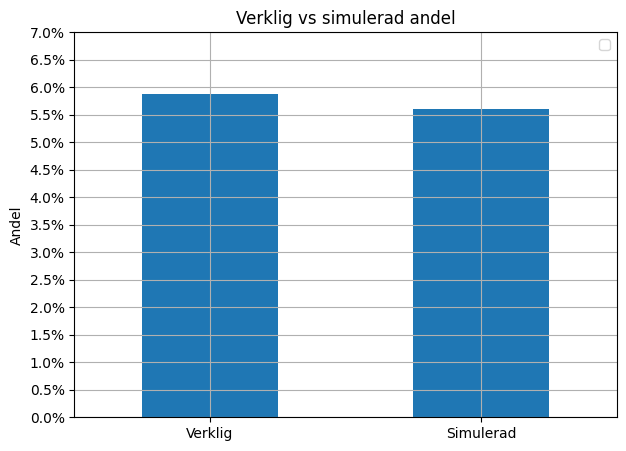

In [55]:
# Visualisering: 
jämf = pd.Series(
    [verklig_andel, simulerad_andel],
    index=["Verklig", "Simulerad"]
).reset_index()

plt.figure()
jämf.plot(kind="bar")
plt.ylabel("Andel")
plt.title("Verklig vs simulerad andel")
plt.xticks([0,1], ["Verklig", "Simulerad"], rotation= 0)
plt.gca().set_yticks(np.arange(0, 0.07, 0.005))
plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")
plt.legend("")
plt.show()

Simuleringen ger ett liknande resultat som vår verkliga andel från orginaldatan.

## Konfidensintervall för blodtryck

### Normal approximation

In [56]:
#Tar fram ett stickprov och räknar ut konfidensintervall med hjälp av normalapproximation
from math import sqrt
np.random.seed(123)

n = 40 
stick= np.random.choice(df.systolic_bp, size= n)
mean_bp = df.systolic_bp.mean()
def ci_mean_normal(x):
    """
    95%-CI för medel med normal-approximation:
    medel ± 1.96 * (s / sqrt(n))
    """
    x = np.asarray(x, dtype=float)
    mean_x = float(np.mean(x))
    s = float(np.std(x, ddof=1))
    n = len(x)
    se = s/sqrt(n)

    z_critical = 1.96
    half_width = z_critical + se
    lo, hi = mean_x - half_width, mean_x + half_width
    return lo, hi, mean_x, s, n, se

lo, hi, mean_stick, s, n, se = ci_mean_normal(stick)
print (f"Medelvärde finns inom blodtryck: {lo:.2f}, {hi:.2f} \n"
       f"Medelvärde för stickprov: {mean_stick:.2f} \n"
       f"Medelvärde från originaldata: {mean_bp:.2f} \n" 
       f"Standard avvikelse: {s:.2f}\n"
       f"Standardfel: {se:.2f}")    

Medelvärde finns inom blodtryck: 145.16, 153.38 
Medelvärde för stickprov: 149.27 
Medelvärde från originaldata: 149.18 
Standard avvikelse: 13.59
Standardfel: 2.15


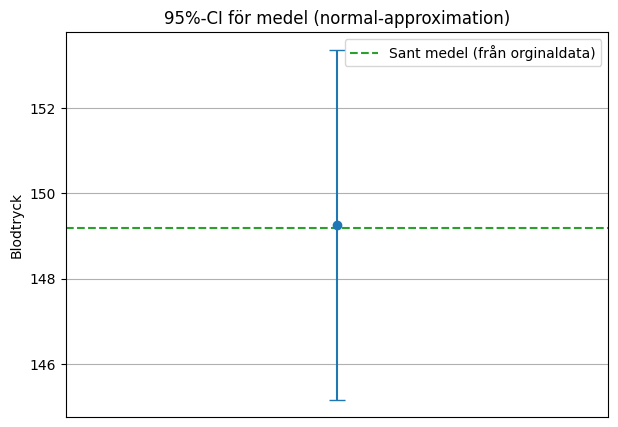

In [57]:
fig, ax = plt.subplots()
ax.errorbar([0], [mean_stick], yerr=[[mean_stick - lo], [hi - mean_stick]], fmt="o", capsize=6)
ax.axhline(mean_bp, color="tab:green", linestyle="--", label="Sant medel (från orginaldata)")
ax.set_xticks([])
ax.set_ylabel("Blodtryck")
ax.grid(True, axis="y")
ax.legend()
ax.set_title("95%-CI för medel (normal-approximation)")
plt.show()

## Bootstrap test 

In [58]:
def ci_mean_bootstrap(x, B= 5000, confidence = 0.95):
    x = np.array(x, dtype = float)
    n = len(x)
    boot_means = np.empty(B)
    for b in range(B):
        boot_sample =  np.random.choice(x, size= n, replace=True)
        boot_means[b] = np.mean(boot_sample)

    alpha = (1 - confidence) / 2
    lo, hi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])
    return float(lo), float(hi), float(np.mean(x)), 
b_lo, b_hi, b_mean= ci_mean_bootstrap(stick)
print(f"Mellan {b_lo:.2f} - {b_hi:.2f} kommer medelvärdet finnas 95% av gångerna, bootstrap medelvärde: {b_mean:.2f}, medelvärde från stickprov {float(mean_bp):.2f}")

Mellan 145.13 - 153.47 kommer medelvärdet finnas 95% av gångerna, bootstrap medelvärde: 149.27, medelvärde från stickprov 149.18


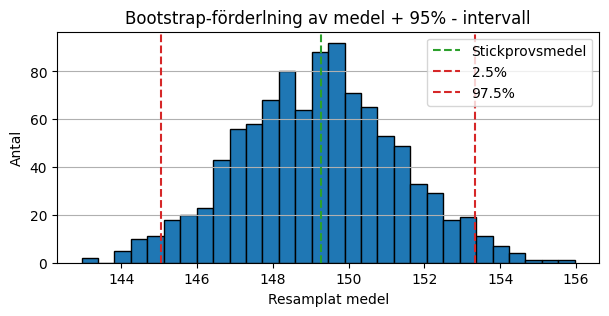

In [59]:
fig, ax = plt.subplots(figsize= (7,3))
boot_info = np.array([np.mean(np.random.choice(stick, size=len(stick), replace= True)) for _ in range(1000)])

ax.hist(boot_info, bins = 30, edgecolor = "black")
ax.axvline(np.mean(stick), color="tab:green", linestyle="--", label="Stickprovsmedel")
ax.axvline(np.percentile(boot_info, 2.5), color="tab:red", linestyle="--", label="2.5%")
ax.axvline(np.percentile(boot_info, 97.5), color="tab:red", linestyle="--", label="97.5%")
ax.set_title("Bootstrap-förderlning av medel + 95% - intervall")
ax.set_xlabel("Resamplat medel")
ax.set_ylabel("Antal")
ax.grid(True, axis="y")
plt.legend()
plt.show()

Diagrammet ovan visar vart medelvärdet för blodtryck hamnar vid 1000 olika stickprov med 40 personer per stickprov.

In [60]:
print(f"Normal-CI: {lo:.2f}, {hi:.2f}")
print(f"Bootstrap-CI: {b_lo:.2f}, {b_hi:.2f}")
print("Stickprovsmedel:", mean_stick, "\nMedelvärde från original data:", mean_bp)

Normal-CI: 145.16, 153.38
Bootstrap-CI: 145.13, 153.47
Stickprovsmedel: 149.27 
Medelvärde från original data: 149.178625


In [61]:
# Testar hur ofta vårt orginal medelvärde fångas av de olika metoderna 
np.random.seed(123)
def covers_true_mean(method = "normal", n=40, trials=200):
    hits = 0
    for _ in range(trials):
        sample = np.random.choice(df.systolic_bp, size=n, replace=True)
        if method == "normal":
            lo, hi, *_ = ci_mean_normal(sample)
        else:
            lo, hi, *_ = ci_mean_bootstrap(sample, B=1500)
        hits += (lo <= mean_bp <= hi)
    return hits / trials


cov_normal = covers_true_mean("normal", n=40, trials=500)
cov_boot = covers_true_mean("bootstrap", n=40, trials=500)

print(f"Test för att se hur ofta de olika metoderna fångar vårt medelvärde:  CI-normal: {cov_normal:.4f}, CI-bootstrap: {cov_boot:.4f}")

Test för att se hur ofta de olika metoderna fångar vårt medelvärde:  CI-normal: 0.9500, CI-bootstrap: 0.9360


Konfidensintervallet för de två metoderna är i princip lika.  
Bottstrap-CI ger ett något större värdespann, men täcker ändå inte medelvärdet oftare än normalapproximation.  
Stickprovsmedlet ligger väldigt nära medelvärdet från orginaldata och kan därför ses som representativt. 

# Hypotesprövning
### Hypotes: Rökare har högre medel-blodtryck än icke-rökare.

In [76]:
smoke_summary = df.groupby("smoker")["systolic_bp"].agg(
    observations = "count",
    proportions = "mean"
).reset_index()

display(smoke_summary)

C:\Users\elin_\AppData\Local\Temp\ipykernel_21084\2304755978.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smoke_summary = df.groupby("smoker")["systolic_bp"].agg(


,smoker,observations,proportions
0,No,587,149.052981
1,Yes,213,149.524883


Metodval: Welch t-test med alternativ greater: Detta då vi jämför två olika stora grupper och antar att rökare har högre blodtryck än den andra. Källa: Joakim Lindh och https://en.wikipedia.org/wiki/Welch%27s_t-test 

In [79]:
from scipy import stats

non_smoker = df.loc[df.smoker == "No", "systolic_bp"].values
is_smoker = df.loc[df.smoker == "Yes", "systolic_bp"].values

t_stat_w, p_val_w = stats.ttest_ind(is_smoker, non_smoker, equal_var=False, alternative = "greater")


print(f"Welch t-test: t = {t_stat_w:.3f}, p = {p_val_w:.4f}")

Welch t-test: t = 0.450, p = 0.3264


Positivt t-värde visar att rökare har ett högre medel blodtryck än icke rökare. Dock är resultatet väldigt nära noll och p-värdet är långt över signifikantnivå på 0,05 vilket gör att vi inte kan utesluta att det inte finns någon skillnad mellan gruppernas blodtryck.

In [64]:
def power_by_simulation(n_sim, mean_non_smoker, mean_is_smoker, n_non_smoker, n_is_smoker, std, n = 1, alpha= 0.05):
    np.random.seed(7)
    count_significant = 0 
    for _ in range(n_sim):
        non_smoker = np.random.normal(mean_non_smoker, std, (n_non_smoker * n))
        is_smoker = np.random.normal(mean_is_smoker, std, (n_is_smoker *n))
        _, p_val = stats.ttest_ind(is_smoker, non_smoker, equal_var=False, alternative = "greater")
        if p_val < alpha: 
            count_significant += 1
    return count_significant / n_sim

In [65]:
n_sim = 5000
alpha = 0.05 
n_non_smoker = smoke_summary["observations"][0]
n_is_smoker = smoke_summary["observations"][1]
mean_non_smoker = smoke_summary["proportions"][0]
mean_is_smoker = smoke_summary["proportions"][1]
std = df["systolic_bp"].std()
n = 1

pwr = power_by_simulation(n_sim, mean_non_smoker, mean_is_smoker, n_non_smoker, n_is_smoker, std, n, alpha)
print(f"Power för observerad skillnad: {pwr}")

Power för observerad skillnad: 0.1136


Med en power på 11,36% kan vi inte dra några säkra slutsatser på att det finns en verklig skillnad mellan gruppernas blodtryck. Ett större deltagar antal behövs för att få ett mer stabilt resultat.

In [66]:
samples_try = [1, 5, 10, 20, 30]
sim_pwr = []
for n in samples_try:
    pwr = power_by_simulation(n_sim, mean_non_smoker, mean_is_smoker, n_non_smoker, n_is_smoker, std, n, alpha)
    sim_pwr.append(pwr)

In [75]:
pd.DataFrame({f"n_non_smoker": n_non_smoker, "n_is_smoker": n_is_smoker, "groupsize_times_n": samples_try, "simulated_power": sim_pwr})

,n_non_smoker,n_is_smoker,groupsize_times_n,simulated_power
0,587,213,1,0.1136
1,587,213,5,0.2734
2,587,213,10,0.4286
3,587,213,20,0.6612
4,587,213,30,0.8058


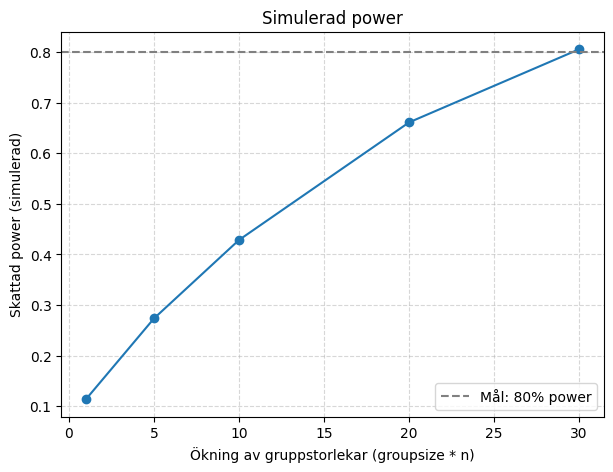

In [68]:
fig, ax = plt.subplots()
V.plot(ax, samples_try, sim_pwr)
plt.show()

In [72]:
pwr_27 = power_by_simulation(n_sim, mean_non_smoker, mean_is_smoker, n_non_smoker, n_is_smoker, std, 27, alpha)
pwr_28 = power_by_simulation(n_sim, mean_non_smoker, mean_is_smoker, n_non_smoker, n_is_smoker, std, 28, alpha)

pwr_27, pwr_28

(0.7678, 0.8054)

In [74]:
need_smokers = n_is_smoker * 28
need_non_smoker = n_non_smoker * 28

need_non_smoker, need_smokers, (need_smokers + need_non_smoker)

(np.int64(16436), np.int64(5964), np.int64(22400))

För att få ett tillräkligt säkert resultat skulle grupperna behöva vara 28 gånger större.   
Det innebär att man skulle behöva ungefär 22 400 deltagare för att få ett tillförlitligt resultat   
och se om det finns någon skillnad i blodtryck mellan rökare och icke rökare. 